# Decomposição de problemas multi-classe.

Para realizar nossos experimentos escolhemos uma base de dados de feijões secos, a qual possui 7 classes distintas

In [1]:
import pandas as pd

data_path = '../data/Dry_Bean_Dataset.xlsx'
beans_data = pd.read_excel(data_path)

sample = beans_data.sample(3)
print(sample)

       Bean ID   Area  Perimeter  MajorAxisLength  MinorAxisLength  \
12632    12633  35168    698.453       250.556503       179.747876   
9031      9032  45849    803.351       300.558016       195.158812   
12321    12322  33796    689.612       257.021439       167.856611   

       AspectRation  Eccentricity  ConvexArea  EquivDiameter    Extent  \
12632      1.393933      0.696667       35615     211.606447  0.712624   
9031       1.540069      0.760514       46301     241.612831  0.700894   
12321      1.531196      0.757285       34210     207.437710  0.696581   

       Solidity  roundness  Compactness  ShapeFactor1  ShapeFactor2  \
12632  0.987449   0.905906     0.844546      0.007125      0.002236   
9031   0.990238   0.892748     0.803881      0.006555      0.001689   
12321  0.987898   0.893029     0.807083      0.007605      0.001990   

       ShapeFactor3  ShapeFactor4     Class  
12632      0.713258      0.994233  DERMASON  
9031       0.646224      0.995230      SIRA  

Devemos tirar todos os atributos da base que são considerados irrelevantes. Nesse caso, retiramos Beans ID. 

In [2]:
X = beans_data.iloc[:,1:-1]
y = beans_data.Class

print(X.sample(1))

       Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
5052  80507   1078.504       423.370841        243.36674      1.739641   

      Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
5052      0.818272       81055     320.163546  0.774299  0.993239   0.869761   

      Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  
5052     0.756225      0.005259      0.001061      0.571876      0.994859  


Após ler nossos dados, precisamos dividi-los em dados de teste e dados de treinamento. Além disso, também vamos normalizar os nossos dados

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Método One versus Rest

Primeiramente o grupo testou o classificador OneVsRestClassifier da biblioteca sklearn

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=13)

ovr = OneVsRestClassifier(model)

ovr.fit(X_train,y_train)

y_pred = ovr.predict(X_test)

Mostrando os resultados do modelo

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.86      0.90       331
      BOMBAY       1.00      1.00      1.00       121
        CALI       0.90      0.96      0.93       408
    DERMASON       0.92      0.93      0.92       874
       HOROZ       0.94      0.94      0.94       470
       SEKER       0.96      0.96      0.96       513
        SIRA       0.87      0.87      0.87       686

    accuracy                           0.92      3403
   macro avg       0.93      0.93      0.93      3403
weighted avg       0.92      0.92      0.92      3403

Confusion matrix:
[[285   0  28   0   3   2  13]
 [  0 121   0   0   0   0   0]
 [  8   0 390   0   7   0   3]
 [  0   0   0 809   0  14  51]
 [  1   0  13   2 442   0  12]
 [  2   0   0   8   0 491  12]
 [  3   0   0  65  16   6 596]]


O grupo optou por fazer a própria implementação do método

Criação dos modelos

In [6]:
import numpy as np

models = []

for label in np.unique(y):
    filter = lambda r:(1 if r == label else -1)
    y_train_class = np.array([filter(row) for row in y_train])
    y_test_class = np.array([filter(row) for row in y_test])

    model = KNeighborsClassifier(n_neighbors=13)
    model.fit(X_train,y_train_class)
    models.append((model,label))

Predição

In [7]:
y_pred = np.empty(len(y_test), dtype='O')
max_prob = np.zeros(len(y_train))

for model in models:
    probability = model[0].predict_proba(X_test)[:,1]
    for i,prob in enumerate(probability):
        if max_prob[i] <= prob:
            max_prob[i] = prob
            y_pred[i] = model[1]

Resultados

In [8]:
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.86      0.90       331
      BOMBAY       1.00      1.00      1.00       121
        CALI       0.90      0.96      0.93       408
    DERMASON       0.92      0.93      0.92       874
       HOROZ       0.94      0.94      0.94       470
       SEKER       0.96      0.96      0.96       513
        SIRA       0.87      0.87      0.87       686

    accuracy                           0.92      3403
   macro avg       0.93      0.93      0.93      3403
weighted avg       0.92      0.92      0.92      3403

Confusion matrix:
[[285   0  28   0   3   2  13]
 [  0 121   0   0   0   0   0]
 [  8   0 390   0   7   0   3]
 [  0   0   0 809   0  14  51]
 [  1   0  13   2 442   0  12]
 [  2   0   0   8   0 491  12]
 [  3   0   0  65  16   6 596]]


Vamos testar o algoritmo com tipos diferentes de modelos

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


modelos = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=13)),
    ('Logistic Regression', LogisticRegression(max_iter=300)),
    ('Naive Bayes', GaussianNB())
]

# Lista para armazenar as acurácias de cada modelo
acuracias = []

# Treine e avalie cada modelo
for nome, modelo in modelos:
    ovr = OneVsRestClassifier(modelo)
    ovr.fit(X_train, y_train)
    y_pred = ovr.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    acuracias.append((nome, acuracia))

Vamos plotar o resultado

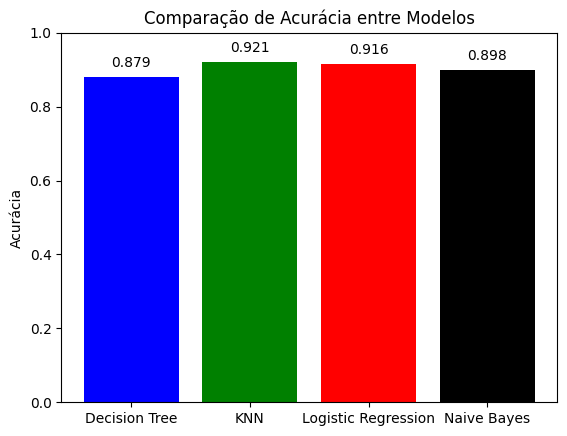

In [10]:
import matplotlib.pyplot as plt

nomes_modelos, valores_acuracia = zip(*acuracias)
barras = plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

for barra in barras:
        altura = barra.get_height()
        plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.02, f'{altura:.3f}', ha='center', va='bottom')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Defina o limite y de 0 a 1 para a acurácia
plt.show()

## Método One versus One

### Adaptive Directed Acyclic Graph 

O grupo implementou não encontrou uma biblioteca que implementasse o ADAG, logo optamos por implementa-lo

Variaveis

In [11]:
class_array = np.unique(y)
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_test_array = np.array(X_test)
lables_data = []
models = np.empty((len(class_array),len(class_array)), dtype='O')
y_pred = np.empty(len(y_test), dtype='O')

Separação dos dados de cada classe

In [12]:
for i,label in enumerate(class_array):
    data = np.array([row for index,row in enumerate(X_train_array) if y_train_array[index] == label])
    lables_data.append(data)

Função de criação dos modelos

In [13]:
def createModels(class_array, model):

    models = np.empty((len(class_array),len(class_array)), dtype='O')
    
    for i in range(len(class_array)):
        for j in range(i+1,len(class_array)):
            x_train_class = []
            for row in lables_data[i]:
                x_train_class.append(row)
            for row in lables_data[j]:
                x_train_class.append(row)


            y_train_class = [1]*len(lables_data[i]) + [0]*len(lables_data[j])
            model = copy.deepcopy(model)
            model.fit(np.array(x_train_class),np.array(y_train_class))
            models[i][j] = model
            models[j][i] = -1

    return models

Função utlizada para gerar a ordem da primeira camada do ADAG

In [14]:
def initialLevel(n_labels):
    first = 0
    second = (n_labels - 1) - n_labels%2
    level = []

    while(first < second):
        level.append(first)
        level.append(second)
        first+=1
        second-=1

    if n_labels%2 > 0:
        level.append(n_labels-1)

    return level


Função de predição das classes

In [15]:
import copy

def predict(X_test_array, class_array, models):
    y_pred = np.empty(len(X_test_array), dtype='O')

    for i,row in enumerate(X_test_array):
        levelLabels = initialLevel(len(class_array))

        while len(levelLabels) != 1:
            next_level = []

            for idx in range(0,len(levelLabels)-1 - (len(levelLabels)%2),2):
                first = min(levelLabels[idx],levelLabels[idx+1])
                second = max(levelLabels[idx],levelLabels[idx+1])

                predicao = models[first][second].predict([row])
                if predicao[0] == 1:
                    next_level.append(first)
                else:
                    next_level.append(second)

            if len(levelLabels)%2 > 0:
                next_level.append(levelLabels[len(levelLabels)-1])



            levelLabels = copy.deepcopy(next_level)

        y_pred[i] = class_array[levelLabels[0]]

    return y_pred

Resultados

In [16]:
models = createModels(class_array,LogisticRegression(max_iter=300))
y_pred = predict(X_test_array,class_array,models)

print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.93      0.89      0.91       331
      BOMBAY       1.00      1.00      1.00       121
        CALI       0.92      0.95      0.93       408
    DERMASON       0.91      0.93      0.92       874
       HOROZ       0.94      0.95      0.95       470
       SEKER       0.96      0.96      0.96       513
        SIRA       0.88      0.86      0.87       686

    accuracy                           0.92      3403
   macro avg       0.93      0.93      0.93      3403
weighted avg       0.92      0.92      0.92      3403

Confusion matrix:
[[295   0  23   0   2   1  10]
 [  0 121   0   0   0   0   0]
 [ 12   0 386   0   7   1   2]
 [  1   0   0 812   0   9  52]
 [  1   0  10   4 447   0   8]
 [  5   0   0   8   0 490  10]
 [  2   0   0  68  19   9 588]]


Comparando a acuracia

In [17]:
algoritmos = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=13)),
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB())
]

acuracias = []

for nome, algoritmo in algoritmos:
    models = createModels(class_array,algoritmo)
    y_pred = predict(X_test_array,class_array,models)
    acuracia = accuracy_score(y_test, y_pred)
    acuracias.append((nome, acuracia))

Plotando

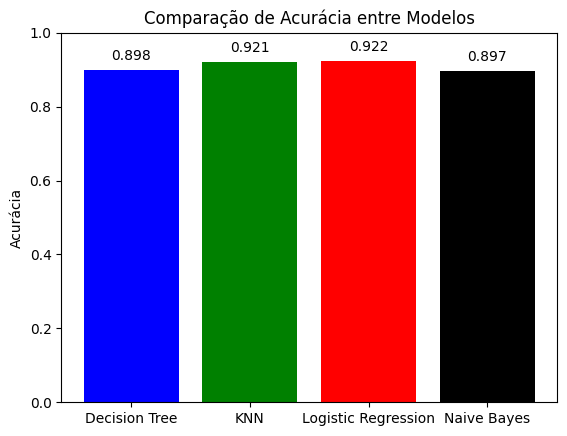

In [18]:
nomes_modelos, valores_acuracia = zip(*acuracias)
plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

barras = plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

for barra in barras:
        altura = barra.get_height()
        plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.02, f'{altura:.3f}', ha='center', va='bottom')

plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Defina o limite y de 0 a 1 para a acurácia
plt.show()


# Método One Vs Rest (Sklearn)

Essas foram todas as bibliotecas usadas nesse algoritmo:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

A leitura dos dados é feita logo abaixo, junto com o tratamento dos dados, tirando a coluna de ID que não é necessária.

In [6]:
# Carrega os dados
dataset_path = r"C:\Users\cauak\Downloads\Data.xlsx"
dataset = pd.read_excel(dataset_path)

# Remove colunas desnecessárias
dataset = dataset.drop("Bean ID", axis=1)

print(dataset.head())

    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332  

Logo abaixo, fazemos a normalização dos dados, exceto da coluna que contém o atributo alvo.

In [7]:
# Nome da coluna do atributo alvo
coluna_atributo_alvo = 'Class'

# Seleciona colunas numéricas para normalização
cols_to_normalize = dataset.select_dtypes(include=['number']).columns.difference([coluna_atributo_alvo])

# Normaliza os dados
scaler = MinMaxScaler()
dataset[cols_to_normalize] = scaler.fit_transform(dataset[cols_to_normalize])

print(dataset.head())

       Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  0.034053   0.058574         0.044262         0.152142      0.122612   
1  0.035500   0.077557         0.030479         0.178337      0.051577   
2  0.038259   0.068035         0.052633         0.158190      0.131521   
3  0.040940   0.082942         0.048548         0.177691      0.091623   
4  0.041504   0.065313         0.032862         0.200679      0.025565   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.477797    0.033107       0.070804  0.671024  0.922824   0.934823   
1      0.278472    0.034991       0.073577  0.735504  0.871514   0.793138   
2      0.496448    0.037126       0.078816  0.716671  0.932141   0.914511   
3      0.403864    0.041389       0.083854  0.731365  0.761614   0.826871   
4      0.165680    0.040123       0.084906  0.700538  0.949832   0.988408   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.7867

Logo após, fizemos a divisão do atributo alvo do restante, e dividimos os dados em treino e teste.

In [9]:
# Separa atributo alvo do restante
X = dataset.drop(coluna_atributo_alvo, axis=1)
y = dataset[coluna_atributo_alvo]

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Criamos também os modelos para testar qual tem o melhor desempenho usando o método pronto e um espaço para ficarem guardadas as médias da validação cruzada.


In [10]:
# Cria e treina modelos
models = {
    'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier()),
    'Naive Bayes': OneVsRestClassifier(GaussianNB()),
    'K Neighbors': OneVsRestClassifier(KNeighborsClassifier()),
    'Logistic Regression': OneVsRestClassifier(LogisticRegression())
}

# Armazena acurácias médias na validação cruzada
cv_results = {'Modelo': [], 'Acurácia Média': [], 'Desvio Padrão Acurácia': []}

Criamos um for para fazer os treinos, as avaliações e também a criação de curvas de aprendizado dos algoritmos.

Acurácia no conjunto de teste para Decision Tree: 0.8817480719794345
Relatório de Classificação para Decision Tree:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.83      0.88       261
      BOMBAY       1.00      0.97      0.99       117
        CALI       0.92      0.89      0.90       317
    DERMASON       0.93      0.84      0.88       671
       HOROZ       0.97      0.92      0.94       408
       SEKER       0.95      0.90      0.92       413
        SIRA       0.70      0.90      0.79       536

    accuracy                           0.88      2723
   macro avg       0.92      0.89      0.90      2723
weighted avg       0.90      0.88      0.89      2723



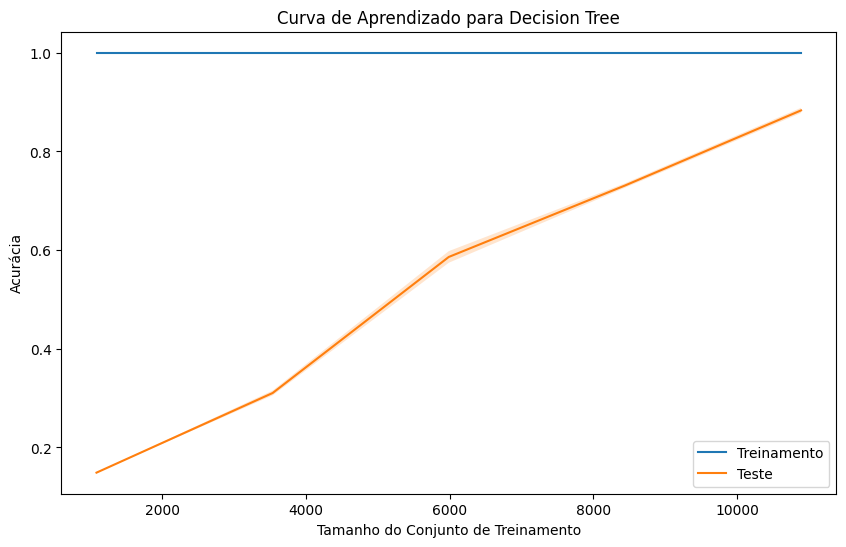

Acurácia no conjunto de teste para Naive Bayes: 0.9063532868160118
Relatório de Classificação para Naive Bayes:
              precision    recall  f1-score   support

    BARBUNYA       0.86      0.80      0.83       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.87      0.90      0.89       317
    DERMASON       0.93      0.88      0.90       671
       HOROZ       0.95      0.97      0.96       408
       SEKER       0.94      0.95      0.94       413
        SIRA       0.85      0.89      0.87       536

    accuracy                           0.91      2723
   macro avg       0.91      0.91      0.91      2723
weighted avg       0.91      0.91      0.91      2723



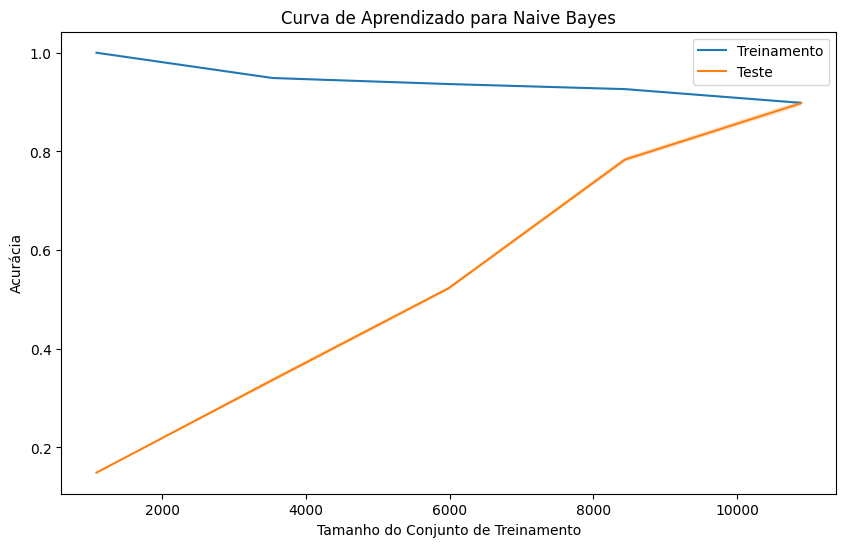

Acurácia no conjunto de teste para K Neighbors: 0.9203084832904884
Relatório de Classificação para K Neighbors:
              precision    recall  f1-score   support

    BARBUNYA       0.96      0.87      0.92       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.91      0.96      0.93       317
    DERMASON       0.90      0.91      0.90       671
       HOROZ       0.97      0.95      0.96       408
       SEKER       0.96      0.94      0.95       413
        SIRA       0.85      0.88      0.87       536

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



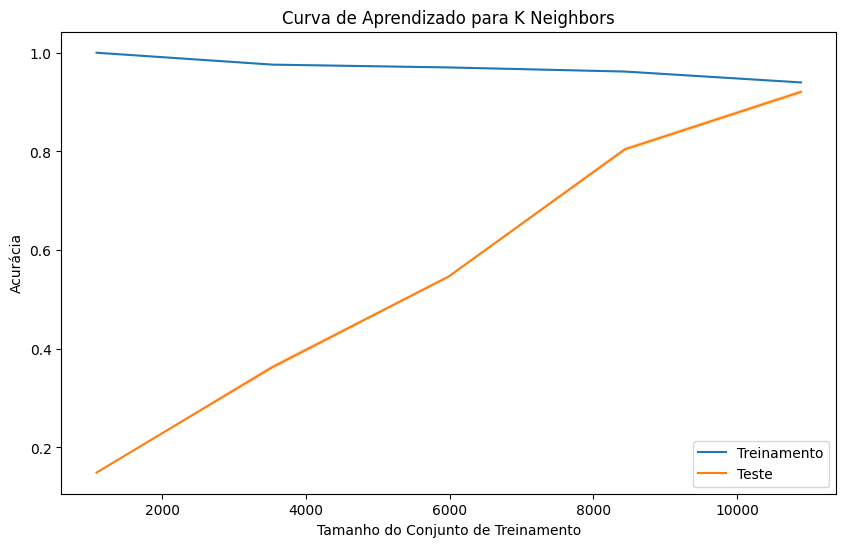

Acurácia no conjunto de teste para Logistic Regression: 0.9107601909658465
Relatório de Classificação para Logistic Regression:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.87      0.91       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.94      0.92      0.93       317
    DERMASON       0.90      0.89      0.90       671
       HOROZ       0.97      0.94      0.96       408
       SEKER       0.96      0.93      0.95       413
        SIRA       0.80      0.88      0.84       536

    accuracy                           0.91      2723
   macro avg       0.93      0.92      0.93      2723
weighted avg       0.91      0.91      0.91      2723



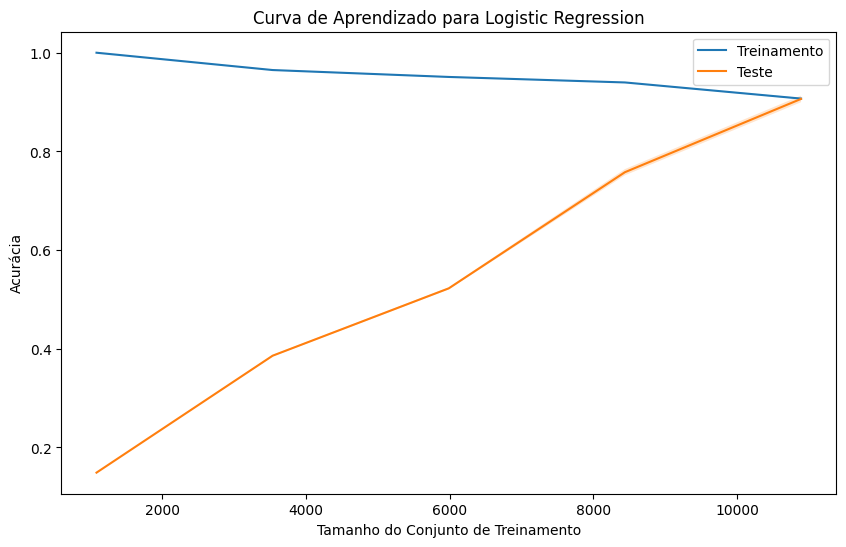

In [11]:
# Avalia e compara modelos
for model_name, model in models.items():
    # Faz previsões no conjunto de teste
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Avaliação do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Acurácia no conjunto de teste para {model_name}: {accuracy}')

    # Relatório de classificação
    print(f'Relatório de Classificação para {model_name}:')
    print(classification_report(y_test, y_pred))

    # Adiciona k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
    
    # Preenche os resultados na tabela
    cv_results['Modelo'].append(model_name)
    cv_results['Acurácia Média'].append(np.mean(cross_val_scores))
    cv_results['Desvio Padrão Acurácia'].append(np.std(cross_val_scores))

    # Adiciona curvas de aprendizado
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1
    )

    # Calcula as médias e desvios padrão
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plota as curvas de aprendizado
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Treinamento')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.plot(train_sizes, test_mean, label='Teste')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Acurácia')
    plt.title(f'Curva de Aprendizado para {model_name}')
    plt.legend()
    plt.show()

No fim, fazemos uma comparação entre as médias na validação cruzada de cada modelo.

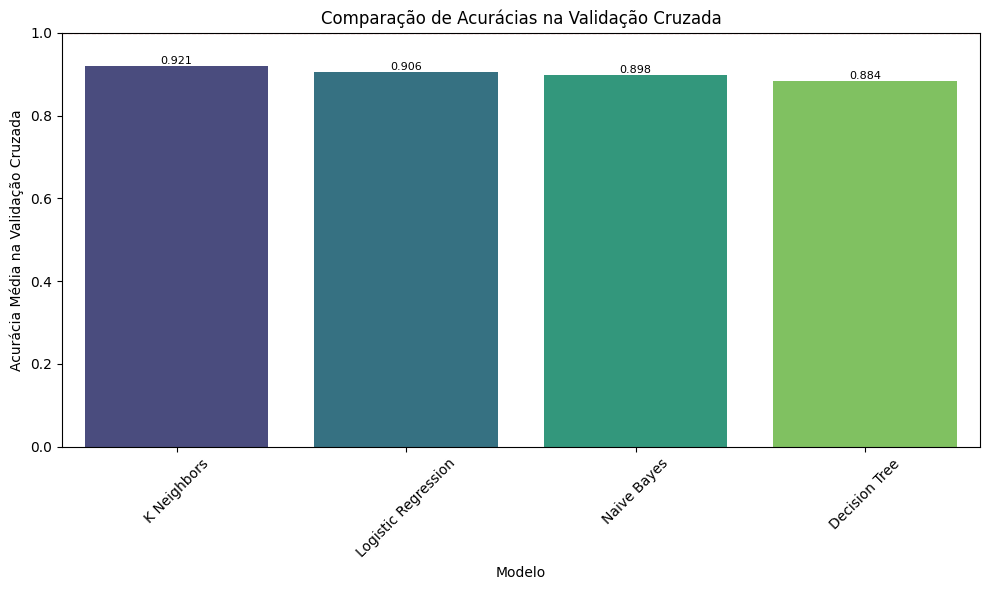

In [15]:
# Cria uma tabela comparativa detalhada das acurácias na validação cruzada
comparison_df = pd.DataFrame(cv_results)

# Ordena o DataFrame pela coluna 'Acurácia Média' em ordem decrescente
comparison_df = comparison_df.sort_values(by='Acurácia Média', ascending=False)

# Plota um gráfico de barras vertical
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Modelo', y='Acurácia Média', hue='Modelo', data=comparison_df, palette='viridis', dodge=False, legend=False)

# Adiciona os valores de acurácia acima das barras
for index, value in enumerate(comparison_df['Acurácia Média']):
    bar_plot.text(index, value, f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# Configurações adicionais para melhor visualização
plt.ylim(0, 1.0)  # Define o limite y de 0 a 1.0
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=0.8)
plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor legibilidade
plt.xlabel('Modelo')
plt.ylabel('Acurácia Média na Validação Cruzada')
plt.title('Comparação de Acurácias na Validação Cruzada')
plt.tight_layout()

# Salva o gráfico como uma imagem
plt.savefig('comparacao_acuracias_modificado.png')

# Exibe o gráfico
plt.show()